In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import CrossEntropyLoss, Linear, Softmax, Sigmoid, Module
import torch.optim as optim
from scipy.optimize import minimize
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.connectors import TorchConnector
import qiskit
import qiskit_machine_learning
print(qiskit.version.get_version_info())
print(qiskit_machine_learning.version.get_version_info())

1.2.4
0.8.0


In [2]:
# Creating Circuit

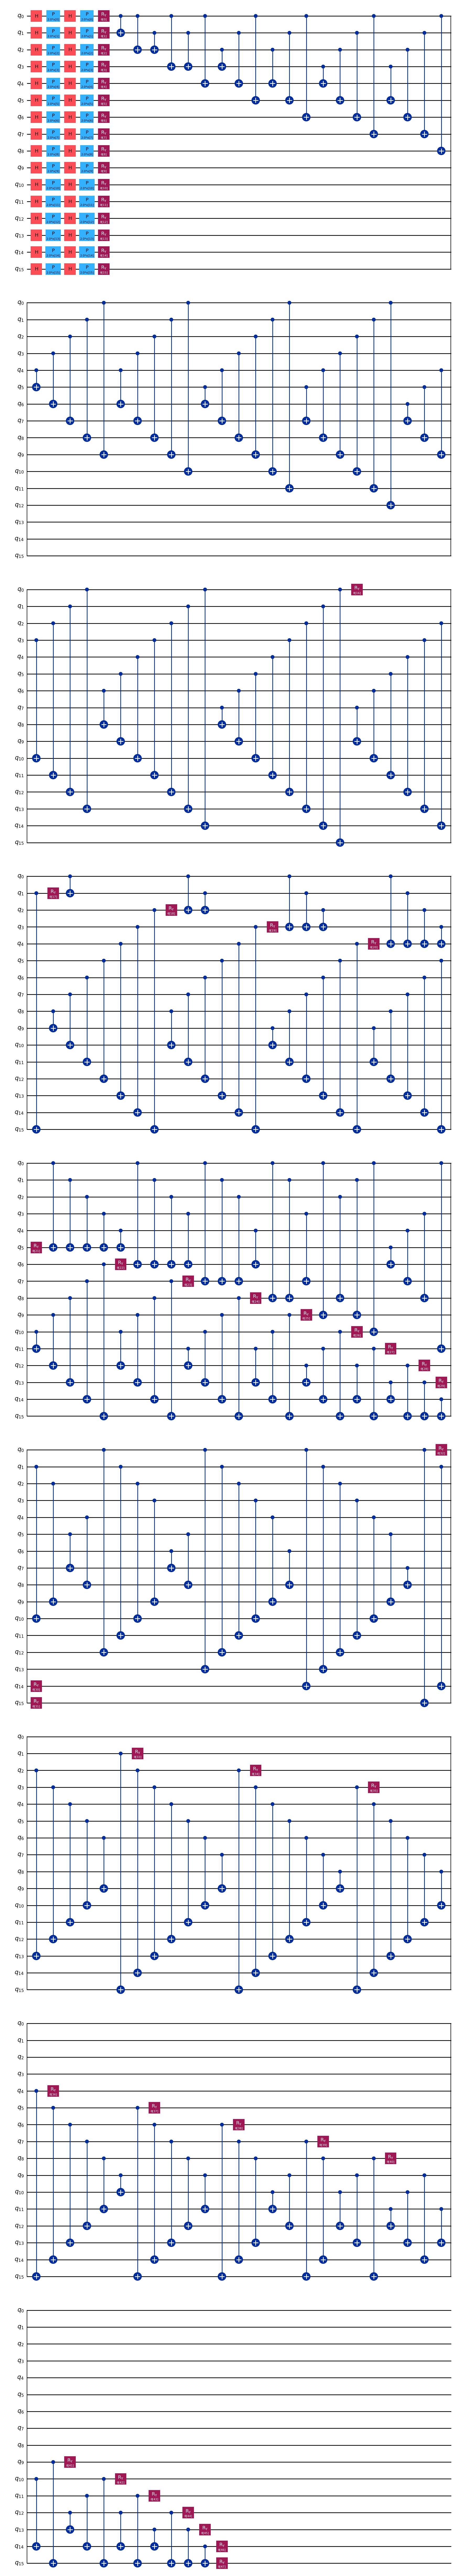

In [3]:
# Ansatz Instantiation Method
from qiskit import ClassicalRegister, QuantumRegister
def create_QCNN():
    feature_map = ZFeatureMap(16)
    ansatz = qiskit.circuit.library.RealAmplitudes(num_qubits=16, entanglement='full', reps=2, name='RealAmplitudes')
    # Combining the feature map and ansatz
    circuit = QNNCircuit(16)
    circuit.feature_map = feature_map
    circuit.ansatz = ansatz
    return circuit

# Visual
display(create_QCNN().decompose().draw("mpl"))

In [4]:
# Creating/Formatting Data

In [5]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/(255.0/np.pi), x_test[..., np.newaxis]/(255.0/np.pi)
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

2024-12-28 17:41:43.817912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735436503.831008  346318 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735436503.835070  346318 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-28 17:41:43.848463: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of original training examples: 60000
Number of original test examples: 10000


In [6]:
# Filter Values
a = 3
b = 4
c = 5
d = 6
def filter_abcd(x, y):
    keep = (y == a) | (y == b) | (y == c) | (y == d)
    x, y = x[keep], y[keep]
    return x,y

In [7]:
# Filtering using previous method.
x_train, y_train = filter_abcd(x_train, y_train)
x_test, y_test = filter_abcd(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 23312
Number of filtered test examples: 3842


6


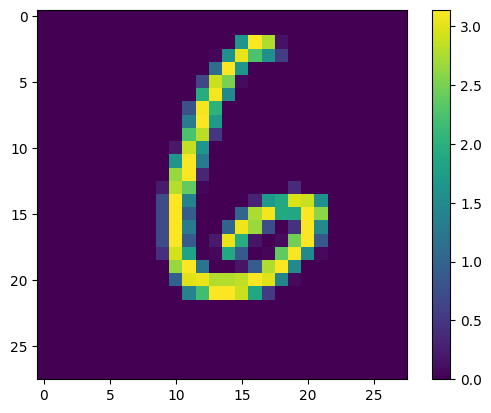

In [8]:
# Displaying Sample Image
img = 13
print(y_train[img])
plt.imshow(x_train[img, :, :, 0])
plt.colorbar()

In [9]:
# Resizing (Quantum Computing Simulation Limit)
x_train_small = tf.image.resize(x_train, (4,4), method = 'area').numpy()
x_test_small = tf.image.resize(x_test, (4,4), method = 'area').numpy()

I0000 00:00:1735436506.330212  346318 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


6


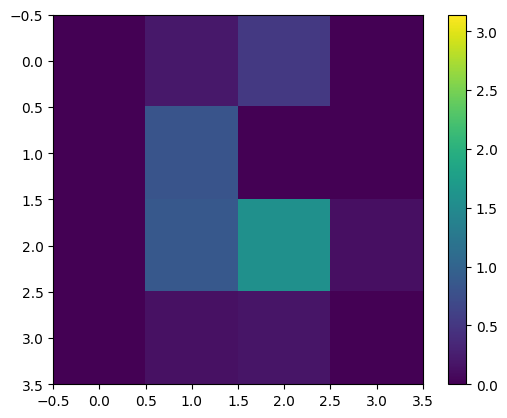

In [10]:
# Displaying Image Sample After Resizing
img = 13
print(y_train[img])
plt.imshow(x_train_small[img,:,:,0], vmin=0, vmax=np.pi)
plt.colorbar()

In [11]:
# Formatting Helper Methods
def format_data(a,b):
    x_reshaped = []
    x1_reshaped = []

    for g in a:
        x_reshaped.append(g.reshape(1,16))

    for g in b:
        x1_reshaped.append(g.reshape(1,16))

    final_x = []
    final_x1 = []

    for entry in x_reshaped:
        final_x.append(entry[0])

    for entry in x1_reshaped:
        final_x1.append(entry[0])
    return final_x, final_x1

def format_labels(y):
    y_temp = []
    for entry in y:
        if entry == a:
            y_temp.append(0)
        elif entry == b:
            y_temp.append(1)
        elif entry == c:
            y_temp.append(2)
        elif entry == d:
            y_temp.append(3)
    return y_temp

In [12]:
x,x1 = format_data(x_train_small, x_test_small)

# Easier to work with names
y = y_train
y1 = y_test

# Setting labels to 0,1,2,3 for easy reference later
y = format_labels(y)
y1 = format_labels(y1)

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)

# Limiting training dataset to lower training time.
x = x[0:256]
y = y[0:256]
x1 = x1[0:256]
y1 = y1[0:256]
print(x)
print(y)

[[0.         0.19058241 0.5850729  ... 1.2083628  0.15663964 0.        ]
 [0.0359542  0.         0.04701703 ... 0.         0.54685587 0.        ]
 [0.         0.26902792 0.86968946 ... 1.3765682  0.4684103  0.        ]
 ...
 [0.         0.3354049  0.         ... 0.40329048 0.46539322 0.        ]
 [0.         0.0548113  0.8850265  ... 0.9554263  0.27833077 0.        ]
 [0.         0.10283405 0.05279988 ... 0.35426205 0.24916515 0.        ]]
[2 1 0 1 0 2 0 3 3 1 1 0 0 3 2 3 3 0 2 0 0 1 1 1 1 3 1 2 3 3 0 3 0 1 3 1 3
 0 2 3 0 0 1 3 1 3 0 1 2 0 0 2 1 1 2 3 0 1 3 3 0 1 1 3 1 2 2 0 0 2 3 2 1 0
 0 3 0 0 1 3 2 3 1 0 0 2 1 3 2 3 0 2 0 0 0 3 1 2 3 2 1 1 2 3 1 2 0 0 2 3 2
 1 0 1 1 1 0 3 3 2 3 1 2 0 3 0 2 1 0 3 2 2 1 1 0 1 1 0 0 1 3 1 1 1 2 1 1 3
 0 3 2 3 1 2 0 2 1 1 1 2 2 3 0 3 3 0 2 1 1 3 0 0 1 2 3 2 0 2 1 0 3 0 3 0 2
 3 0 2 2 3 0 2 2 2 2 2 1 3 3 2 0 1 2 2 0 3 0 2 0 0 1 3 1 0 1 3 2 0 1 1 3 3
 3 1 1 3 2 0 2 1 2 2 3 2 0 3 2 0 0 1 3 2 2 1 3 0 3 1 1 3 0 3 0 1 2 1]


In [13]:
# Additional Helper Functions
def count(y):
    counta = 0
    countb = 0
    countc = 0
    countd = 0
    for i in range(len(y)):
        if y[i] == 0:
            counta+=1
        elif y[i] == 1:
            countb+=1
        elif y[i] == 2:
            countc+=1
        elif y[i] == 3:
            countd+=1
    return(counta, countb, countc, countd)

def balance_lists(x, y, max_count):
    """Balances two lists x and y based on the values in y (0 or 1)."""
    
    x_balanced = []
    y_balanced = []
    count0 = 0
    count1 = 0
    count2 = 0
    count3 = 0

    for i in range(len(y)):
        if y[i] == 0:
            if count0 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count0 += 1
        elif y[i] == 1:
            if count1 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count1 += 1
        elif y[i] == 2:
            if count2 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count2 += 1
        elif y[i] == 3:
            if count3 < max_count:
                x_balanced.append(x[i])
                y_balanced.append(y[i])
                count3 += 1
    return x_balanced, y_balanced

def shuffle(arr1, arr2):
    assert len(arr1) == len(arr2)
    p = np.random.permutation(len(arr1))
    return arr1[p], arr2[p]

In [14]:
# Further Data Cleaning Using Helper Functions
nums = count(y)
print("original:", nums)
max_count = min(nums)
print("max_count =", max_count)
x,y = balance_lists(x, y, max_count)

print("balanced:", count(y))

# Converting to nparray
x = np.asarray(x)
y = np.asarray(y)
x1 = np.asarray(x1)
y1 = np.asarray(y1)
objective_func_vals = []

x,y = shuffle(x,y)
print("shuffled:", count(y))

print("final:", x)
print(y)

original: (66, 68, 60, 62)
max_count = 60
balanced: (60, 60, 60, 60)
shuffled: (60, 60, 60, 60)
final: [[0.         0.         0.21698233 ... 0.9589463  0.03042278 0.        ]
 [0.         0.85133517 0.21673094 ... 0.49682167 0.734924   0.        ]
 [0.         0.28511932 0.0206171  ... 0.         0.39851335 0.        ]
 ...
 [0.         0.41334757 0.2755651  ... 0.3816677  0.48802173 0.        ]
 [0.         0.         0.11842258 ... 0.27305079 0.23483373 0.        ]
 [0.         0.         0.         ... 0.3932333  0.01407997 0.        ]]
[0 0 1 0 2 2 1 0 1 0 2 2 3 0 0 2 2 2 1 2 2 0 2 3 0 2 2 1 0 2 0 0 3 1 3 0 2
 1 1 1 2 1 2 1 3 3 2 2 1 3 1 1 3 2 3 2 3 2 3 3 3 2 1 3 3 2 3 2 1 3 3 1 3 0
 0 0 2 3 0 3 3 2 1 3 2 3 2 3 2 1 0 3 0 1 0 1 1 0 1 1 0 1 1 0 3 1 1 1 2 1 1
 1 1 3 1 0 2 1 2 1 0 2 2 0 0 2 3 3 3 3 1 0 0 3 3 2 3 1 1 0 0 2 0 3 2 1 3 0
 1 2 1 3 1 1 1 0 1 3 2 3 0 2 0 3 3 1 0 3 3 0 2 3 2 2 1 3 2 0 0 1 1 3 0 3 3
 0 2 2 2 2 0 2 1 1 2 0 3 0 0 0 0 1 2 1 0 3 3 1 1 0 2 0 2 3 3 0 2 1 3 0 2 0
 0 

In [15]:
# Tensor for Pytorch
X = torch.tensor(x, dtype=torch.float32).to("cuda")
Y = torch.tensor(y, dtype=torch.long).to("cuda")
X1 = torch.tensor(x1, dtype=torch.float32).to("cuda")
Y1 = torch.tensor(y1, dtype=torch.long).to("cuda")

In [16]:
# One-Hot Encoding for Final Processing
num_classes = 4
Y = (torch.nn.functional.one_hot(Y, num_classes=num_classes).float())
Y1 = (torch.nn.functional.one_hot(Y1, num_classes=num_classes).float())

In [17]:
print(X,Y,X1,Y1)

tensor([[0.0000, 0.0000, 0.2170,  ..., 0.9589, 0.0304, 0.0000],
        [0.0000, 0.8513, 0.2167,  ..., 0.4968, 0.7349, 0.0000],
        [0.0000, 0.2851, 0.0206,  ..., 0.0000, 0.3985, 0.0000],
        ...,
        [0.0000, 0.4133, 0.2756,  ..., 0.3817, 0.4880, 0.0000],
        [0.0000, 0.0000, 0.1184,  ..., 0.2731, 0.2348, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.3932, 0.0141, 0.0000]],
       device='cuda:0') tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
      

In [18]:
# Training

In [19]:
# Pytorch Circuit Module
import torch.nn as nn
class Model(Module): # Simplified
    def __init__(self, qnn_module):
        super().__init__()
        self.qnn_module = qnn_module
        self.fc = nn.Linear(16,4)

    def forward(self, x):
        x = self.qnn_module(x)
        x = self.fc(x)
        return x

In [20]:
from qiskit_aer.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_algorithms.gradients import ReverseEstimatorGradient
from qiskit_machine_learning.utils import algorithm_globals

# Reproducable seeds
num_qubits = 16
algorithm_globals.random_seed = 65
seed = 90

# Creating GPU compatible Estimator primitive
sampler = Estimator()
sampler.set_options(device='GPU')
sampler.set_options(method="statevector")
sampler.set_options(seed = seed)

observable_z0 = SparsePauliOp.from_sparse_list([("Z", [0], 1)], num_qubits=num_qubits)
observable_z1 = SparsePauliOp.from_sparse_list([("Z", [1], 1)], num_qubits=num_qubits)
observable_z2 = SparsePauliOp.from_sparse_list([("Z", [2], 1)], num_qubits=num_qubits)
observable_z3 = SparsePauliOp.from_sparse_list([("Z", [3], 1)], num_qubits=num_qubits)
observable_z4 = SparsePauliOp.from_sparse_list([("Z", [4], 1)], num_qubits=num_qubits)
observable_z5 = SparsePauliOp.from_sparse_list([("Z", [5], 1)], num_qubits=num_qubits)
observable_z6 = SparsePauliOp.from_sparse_list([("Z", [6], 1)], num_qubits=num_qubits)
observable_z7 = SparsePauliOp.from_sparse_list([("Z", [7], 1)], num_qubits=num_qubits)
observable_z8 = SparsePauliOp.from_sparse_list([("Z", [8], 1)], num_qubits=num_qubits)
observable_z9 = SparsePauliOp.from_sparse_list([("Z", [9], 1)], num_qubits=num_qubits)
observable_z10 = SparsePauliOp.from_sparse_list([("Z", [10], 1)], num_qubits=num_qubits)
observable_z11 = SparsePauliOp.from_sparse_list([("Z", [11], 1)], num_qubits=num_qubits)
observable_z12 = SparsePauliOp.from_sparse_list([("Z", [12], 1)], num_qubits=num_qubits)
observable_z13 = SparsePauliOp.from_sparse_list([("Z", [13], 1)], num_qubits=num_qubits)
observable_z14 = SparsePauliOp.from_sparse_list([("Z", [14], 1)], num_qubits=num_qubits)
observable_z15 = SparsePauliOp.from_sparse_list([("Z", [15], 1)], num_qubits=num_qubits)
observables = [observable_z0, observable_z1, observable_z2, observable_z3, observable_z4, observable_z5, observable_z6, observable_z7, observable_z8, observable_z9, observable_z10, observable_z11, observable_z12, observable_z13, observable_z14, observable_z15]

# Instantiating underlying EstimatorQNN
estimator = EstimatorQNN(
    estimator = sampler,
    circuit = create_QCNN(),
    gradient = ReverseEstimatorGradient(sampler),
    observables=observables,
    input_gradients = True,
)

# Initial Forward Weights
weights = algorithm_globals.random.random(estimator.num_weights)

# Checking Data Forward Result
estimator.forward(input_data = x1[:30], weights = weights)

/tmp/ipykernel_346318/2617119476.py:36: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  estimator = EstimatorQNN(
/tmp/ipykernel_346318/2617119476.py:36: UserWarning: No number of qubits was not specified (None) and was retrieved from `circuit` (16). If `circuit` is transpiled, this may cause unstable behaviour.
  estimator = EstimatorQNN(


array([[ 0.82617188,  0.41210938,  0.359375  ,  0.45898438,  0.47851562,
         0.09375   , -0.00585938, -0.43359375, -0.25976562, -0.12304688,
        -0.2734375 , -0.1484375 , -0.54492188,  0.37304688, -0.02539062,
        -0.015625  ],
       [ 0.828125  ,  0.31640625,  0.38671875,  0.28125   ,  0.4140625 ,
        -0.01757812, -0.16992188, -0.56445312, -0.515625  ,  0.34765625,
        -0.3671875 ,  0.51171875, -0.33007812,  0.34179688, -0.09179688,
         0.2421875 ],
       [ 0.84765625,  0.50976562, -0.00195312,  0.26953125,  0.04882812,
         0.359375  ,  0.09570312, -0.22851562,  0.0390625 , -0.43554688,
        -0.33007812, -0.51171875, -0.53710938,  0.3828125 ,  0.08398438,
         0.11523438],
       [ 0.78710938, -0.08398438,  0.453125  ,  0.02734375,  0.44335938,
         0.        , -0.09179688, -0.25976562, -0.34570312, -0.21875   ,
        -0.28515625, -0.54296875, -0.27929688, -0.125     ,  0.39453125,
        -0.29492188],
       [ 0.78515625, -0.13867188,  0

In [21]:
# Wrapping estimator with initial weights under TorchConnecter, itself under Pytorch Module.
model = Model(TorchConnector(estimator, weights))
model.to("cuda")
next(model.parameters()).is_cuda

True

In [22]:
model(X[:20])

tensor([[-0.2589, -0.2042, -0.2920,  0.5592],
        [-0.6431, -0.2851, -0.0958, -0.0206],
        [-0.0783,  0.0731, -0.0420, -0.2982],
        [-0.2756,  0.0169, -0.1189,  0.4102],
        [-0.2090, -0.0483,  0.1357,  0.1172],
        [-0.1170, -0.4177, -0.2305,  0.4287],
        [-0.2590, -0.2213, -0.0965, -0.0354],
        [-0.2900, -0.1179,  0.0523,  0.0115],
        [-0.0546, -0.2756, -0.2384,  0.3815],
        [-0.1400, -0.1822, -0.1111,  0.1064],
        [-0.2578, -0.0465,  0.0263, -0.3377],
        [-0.2731, -0.3377, -0.0504,  0.0784],
        [-0.1154, -0.1780,  0.0070,  0.0541],
        [-0.1377, -0.4180, -0.3205,  0.2013],
        [-0.2218, -0.1735, -0.0901,  0.2439],
        [-0.2215, -0.0152, -0.0048, -0.2334],
        [-0.3268,  0.0618, -0.0796, -0.1147],
        [-0.2516,  0.0706, -0.1079, -0.1279],
        [-0.2880, -0.2272, -0.1318,  0.5244],
        [-0.1526, -0.4035, -0.2088,  0.2754]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [23]:
def accuracy(output, y):
    preds = torch.argmax(output, dim=1)
    true = torch.argmax(y, dim=1)
    correct = (preds == true).sum().item()
    return (correct / y.size(0)) * 100

In [24]:
def train(model, X, Y, loss_function, optimizer, epochs, loss_list = [], acc_list = [], test_acc_list=[], i = 0):
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    if i == 0:
        output = model(X)
        output0 = model(X1)
        epoch_loss = loss_function(output, Y).item()
        epoch_acc = accuracy(output, Y)
        epoch_test_acc = accuracy(output0, Y1)
        loss_list.append(epoch_loss)
        acc_list.append(epoch_acc)
        test_acc_list.append(epoch_test_acc)
        print(f"Epoch: {i}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Test Accuracy: {epoch_test_acc:.2f}%")
    else:
        for e in range(i+1): # Considering 0th epoch in list as well
            print(f"Epoch: {e}, Loss: {loss_list[e]:.4f}, Accuracy: {acc_list[e]:.2f}%, Test Accuracy: {test_acc_list[e]:.2f}%")   
        
    for epoch in range(epochs):
        # Forward pass
        output = model(X)
        loss = loss_function(output, Y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate loss and accuracy for the entire epoch (optional, for monitoring)
        with torch.no_grad():
            output = model(X)
            output0 = model(X1)
            epoch_loss = loss_function(output, Y).item()
            epoch_acc = accuracy(output, Y)
            epoch_test_acc = accuracy(output0, Y1)
            loss_list.append(epoch_loss)
            acc_list.append(epoch_acc)
            test_acc_list.append(epoch_test_acc)
            print(f"Epoch: {epoch+1+i}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Test Accuracy: {epoch_test_acc:.2f}%")
    return loss_list, acc_list, test_acc_list

In [25]:
optimizer = optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_function = CrossEntropyLoss()

In [34]:
# Train the Model
loss_list, acc_list, test_acc_list = train(model = model, X = X, Y = Y, optimizer = optimizer, loss_function = loss_function, epochs = 15, i = 15, loss_list=loss_list, acc_list=acc_list, test_acc_list=test_acc_list)

Epoch: 0, Loss: 1.4428, Accuracy: 22.50%, Test Accuracy: 19.14%
Epoch: 1, Loss: 1.3004, Accuracy: 39.58%, Test Accuracy: 41.80%
Epoch: 2, Loss: 1.1800, Accuracy: 62.50%, Test Accuracy: 57.42%
Epoch: 3, Loss: 1.0708, Accuracy: 65.83%, Test Accuracy: 58.59%
Epoch: 4, Loss: 0.9653, Accuracy: 68.75%, Test Accuracy: 58.20%
Epoch: 5, Loss: 0.8690, Accuracy: 71.67%, Test Accuracy: 60.94%
Epoch: 6, Loss: 0.7954, Accuracy: 70.83%, Test Accuracy: 61.33%
Epoch: 7, Loss: 0.7505, Accuracy: 70.00%, Test Accuracy: 62.89%
Epoch: 8, Loss: 0.7088, Accuracy: 69.58%, Test Accuracy: 62.11%
Epoch: 9, Loss: 0.6742, Accuracy: 72.92%, Test Accuracy: 65.23%
Epoch: 10, Loss: 0.6527, Accuracy: 70.00%, Test Accuracy: 67.97%
Epoch: 11, Loss: 0.6291, Accuracy: 71.25%, Test Accuracy: 71.88%
Epoch: 12, Loss: 0.6177, Accuracy: 72.08%, Test Accuracy: 73.83%
Epoch: 13, Loss: 0.5956, Accuracy: 72.08%, Test Accuracy: 75.00%
Epoch: 14, Loss: 0.5722, Accuracy: 75.00%, Test Accuracy: 75.39%
Epoch: 15, Loss: 0.5543, Accuracy: 

/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 16, Loss: 0.5288, Accuracy: 78.75%, Test Accuracy: 77.34%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 17, Loss: 0.5452, Accuracy: 77.08%, Test Accuracy: 74.22%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 18, Loss: 0.5142, Accuracy: 79.17%, Test Accuracy: 80.08%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 19, Loss: 0.4776, Accuracy: 81.67%, Test Accuracy: 76.17%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 20, Loss: 0.4860, Accuracy: 80.42%, Test Accuracy: 73.05%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 21, Loss: 0.4697, Accuracy: 83.33%, Test Accuracy: 75.39%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 22, Loss: 0.4483, Accuracy: 85.42%, Test Accuracy: 78.91%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 23, Loss: 0.4510, Accuracy: 83.33%, Test Accuracy: 78.52%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 24, Loss: 0.4419, Accuracy: 83.33%, Test Accuracy: 77.73%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 25, Loss: 0.4343, Accuracy: 84.17%, Test Accuracy: 75.00%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 26, Loss: 0.4193, Accuracy: 83.75%, Test Accuracy: 77.73%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 27, Loss: 0.4140, Accuracy: 84.58%, Test Accuracy: 77.73%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 28, Loss: 0.4143, Accuracy: 83.33%, Test Accuracy: 77.34%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 29, Loss: 0.3951, Accuracy: 86.25%, Test Accuracy: 78.52%


/home/himankhanda/projects/QiskitPolygence/QAI Algorithms/.venv/lib/python3.12/site-packages/qiskit_algorithms/gradients/base/base_estimator_gradient.py:258: ComplexWarning: Casting complex values to real discards the imaginary part
  gradient[i] += (


Epoch: 30, Loss: 0.3882, Accuracy: 85.00%, Test Accuracy: 79.69%


In [35]:
print(loss_list, acc_list, test_acc_list)

[1.4428375959396362, 1.3003674745559692, 1.1800163984298706, 1.0708425045013428, 0.965308427810669, 0.8689606785774231, 0.7954150438308716, 0.7505263686180115, 0.7087697982788086, 0.6741976737976074, 0.6526713967323303, 0.6290532946586609, 0.6176664233207703, 0.5955961346626282, 0.5721831917762756, 0.5542662739753723, 0.5288176536560059, 0.5452438592910767, 0.514165997505188, 0.4775916635990143, 0.48603665828704834, 0.4696897864341736, 0.44834595918655396, 0.4510132670402527, 0.44192948937416077, 0.43431392312049866, 0.41933557391166687, 0.4139882028102875, 0.41430485248565674, 0.3950500190258026, 0.38824188709259033] [22.5, 39.58333333333333, 62.5, 65.83333333333333, 68.75, 71.66666666666667, 70.83333333333334, 70.0, 69.58333333333333, 72.91666666666666, 70.0, 71.25, 72.08333333333333, 72.08333333333333, 75.0, 76.66666666666667, 78.75, 77.08333333333334, 79.16666666666666, 81.66666666666667, 80.41666666666667, 83.33333333333334, 85.41666666666666, 83.33333333333334, 83.33333333333334,

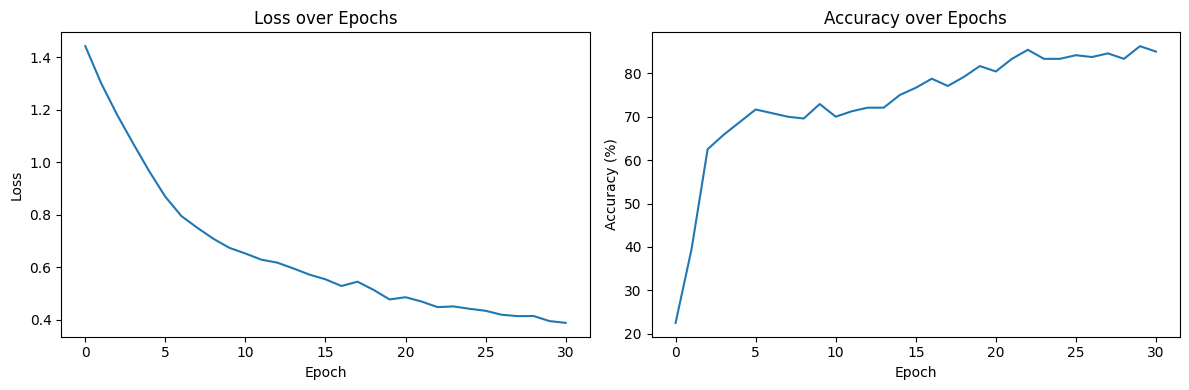

In [36]:
# Plot Loss and Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_list)
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(acc_list)
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.tight_layout()
plt.show()

In [37]:
savemodel = {'model': model, 'optimizer': optimizer.state_dict()}
print(next(model.parameters()).is_cuda)
torch.save(savemodel, "BasicCircuitFull")
print(next(model.parameters()).is_cuda)

True
True


In [38]:
evalmodel = torch.load("BasicCircuitFull", weights_only=False)['model'].to("cuda")
evalmodel.eval()
output0 = evalmodel(X)
output1 = evalmodel(X1)
print(f"Train Accuracy: {accuracy(output0, Y)}%")
print(f"Test Accuracy: {accuracy(output1, Y1)}%")

Train Accuracy: 85.0%
Test Accuracy: 79.6875%


In [39]:
def translate(array):
    arr = []
    for e in array:
        arr.append(torch.argmax(e))
    return arr
print(f"output 0: {translate(output0)}, \n Y:       {translate(Y)}, \n output 1: {translate(output1)}, \n Y1:       {translate(Y1)}")

output 0: [tensor(2, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(3, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(1, device='cuda:0'), tensor(2, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(3, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(3, device='cuda:0'), tensor(1, device='cuda:0'), tensor(3, device='cuda:0'), tensor(0,

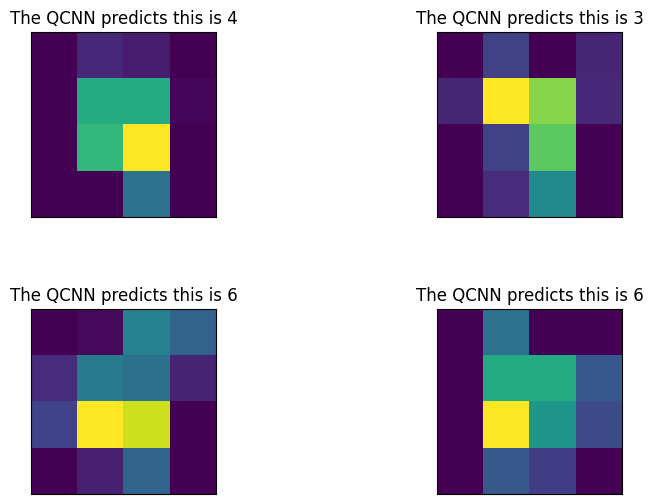

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(0, 4):
    ax[i // 2, i % 2].imshow(X1.detach().cpu().numpy()[i].reshape(4, 4), aspect="equal")
    if torch.argmax(output1[i]) == 0:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 3")
    if torch.argmax(output1[i]) == 1:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 4")
    if torch.argmax(output1[i]) == 2:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 5")
    if torch.argmax(output1[i]) == 3:
        ax[i // 2, i % 2].set_title("The QCNN predicts this is 6")
plt.subplots_adjust(wspace=0.1, hspace=0.5)

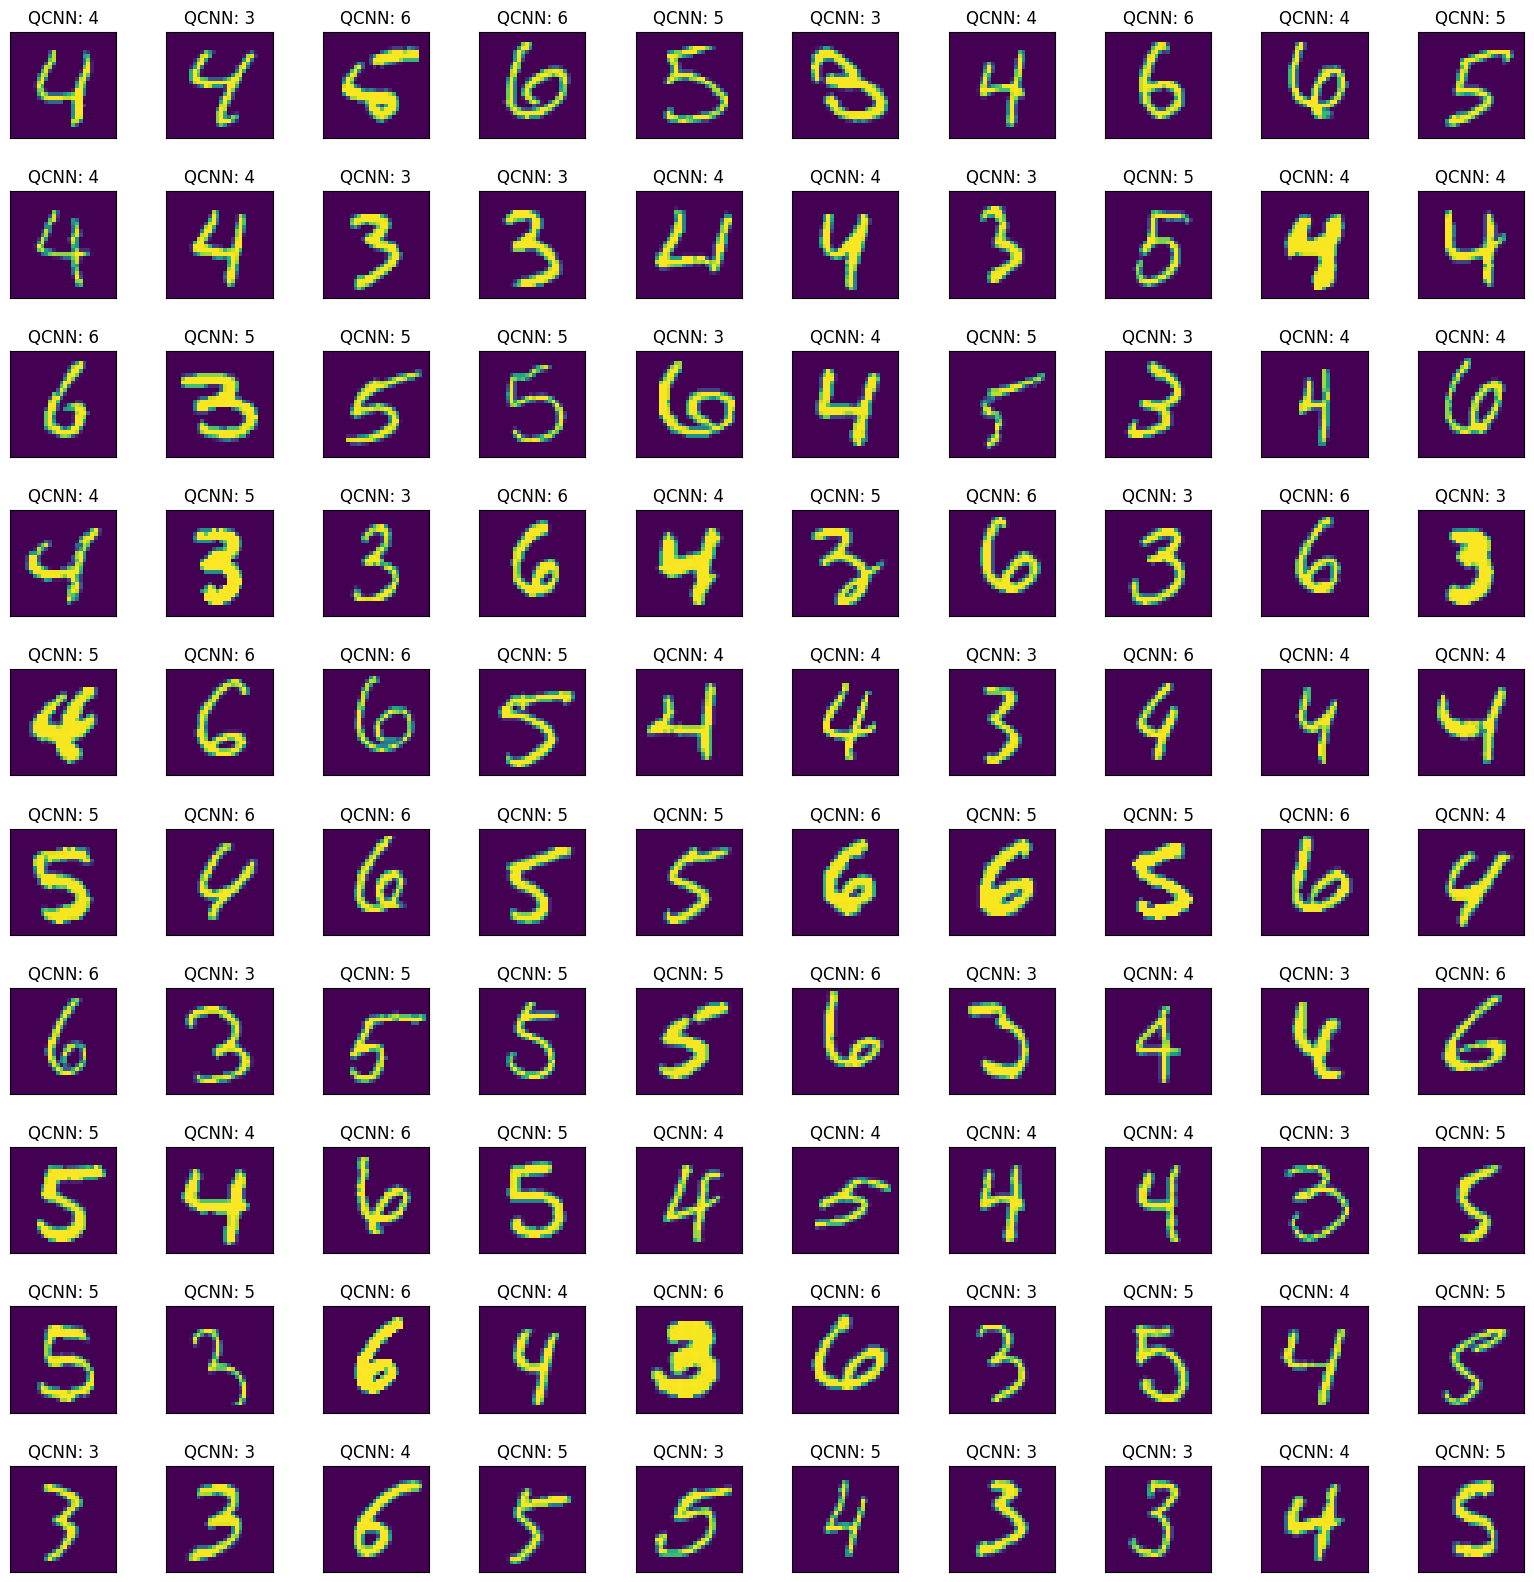

In [41]:
num_rows = 10
num_cols = 10
fig, ax = plt.subplots(num_rows, num_cols, figsize=(20, 20),
                       subplot_kw={"xticks": [], "yticks": []})

for i in range(num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    
    if i < len(x_test) and i < len(output1):
      ax[row, col].imshow(x_test[i].reshape(28, 28), aspect="equal")

      if torch.argmax(output1[i]) == 0:
          ax[row, col].set_title("QCNN: 3")
      elif torch.argmax(output1[i]) == 1:
          ax[row, col].set_title("QCNN: 4")
      elif torch.argmax(output1[i]) == 2:
          ax[row, col].set_title("QCNN: 5")
      elif torch.argmax(output1[i]) == 3:
          ax[row, col].set_title("QCNN: 6")
    else:
        ax[row, col].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.show()